# Improve Zillow's Home Value Prediction Algorithm

Build a model to improve the Zestimate residual error - the error between the Zillow's estimate of a house's sale price and latter's actual sale price.

#### Import libraries necessary for this project

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlp
import sklearn.learning_curve as curves
import xgboost as xgb
import warnings
import pydot
from sklearn.ensemble import GradientBoostingRegressor
from time import time
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import grid_search
from sklearn.cross_validation import ShuffleSplit
from matplotlib.pyplot import colorbar
from matplotlib.text import Text
from sklearn.learning_curve import learning_curve
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from ggplot import ggplot, geom_line, aes
from ggplot import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_predict
from scipy import stats
from IPython.display import display # Allows the use of display() for DataFrames
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
%matplotlib inline

#### Tuning the default settings for easy reading 

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 4000
warnings.filterwarnings("ignore")

## 1. Helpers

In [295]:
def plot_corr(df):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    plt.figure(figsize = (12,12))
    sns.heatmap(corr)
    plt.title("Important variables correlation map", fontsize=15)
    plt.show()    
    
def box_plot(df,label):
    x = df[label]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True ,
                                        gridspec_kw={"height_ratios": (.15, .85)})
    me = np.mean(x)
    st = x.std(); 
    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist, kde=False)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xlim([me-2*st, me+2*st])
    plt.show()
    
def fillna_knn( df, base, target, fraction = 1, threshold = 10, n_neighbors = 5 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
        
    Y = X_target[ target ].values.reshape((-1,1)) 
    X = X_target[ base  ]

    n_neighbors = n_neighbors
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    Z = clf.predict(df.loc[miss, base])
    df.loc[ miss, target ]  = Z
    
def fillna_knn_reg( df, base, target, n_neighbors = 5 ):
    cols = base + [target]
    
    X_ = df[base].values.reshape(-1, 1)
    
    #Take those values from X_train[base] that correspond to non-null values of target, using latter's indices.
    #Both X_train and Y_train will have data corresponing to same indices
    
    X_train = X_[df[target].notnull()]
    Y_train = df.loc[df[target].notnull(),target].values.reshape(-1, 1)

    knn = KNeighborsRegressor(n_neighbors, n_jobs = -1)    
    
    # fitting the model
    knn.fit(X_train, Y_train)
    
    # predict the response
    X_test = X_[df[target].isnull()]
    pred = knn.predict(X_test)
    df.loc[df_train[target].isnull(),target] = pred
    return

def plot_jointplot(df,feature1,feature2):
    color = sns.color_palette()
    plt.figure(figsize=(12,12))
    sns.jointplot(x=df[feature1].values, y=df[feature2].values, size=10, color=color[4])
    plt.ylabel(feature2, fontsize=12)
    plt.xlabel(feature1, fontsize=12)
    plt.title(feature1 + " Vs " + feature2, fontsize=15)
    plt.show()
    
def plot_countPlot(df,label):
    plt.figure(figsize=(12,8))
    sns.countplot(x=label, data=df)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(label, fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("Frequency of "+ label +" count", fontsize=15)
    plt.show()
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def performance_metric(estimator,X,y):
    return mean_absolute_error(y,estimator.predict(X))

## 2. Dataset

#### Load the properties dataset for 2016 and 2017.

In [4]:
try:
    data = pd.read_csv("properties_2017.csv")
    dataO = pd.read_csv("properties_2016.csv")
    print "dataset has {} samples with {} features each.".format(*data.shape)
    print "Older dataset has {} samples with {} features each.".format(*dataO.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

dataset has 2985217 samples with 58 features each.
Older dataset has 2985217 samples with 58 features each.


#### Load the transactions file for 2016 and 2017. This is file that holds the details of all transactions that took place for a property in these two years. 

In [5]:
try:
    trans = pd.read_csv("train_2017.csv")
    transO = pd.read_csv("train_2016.csv")
    print "transaction dataset has {} samples with {} features each.".format(*trans.shape)
    print "Older transaction dataset has {} samples with {} features each.".format(*transO.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

transaction dataset has 77613 samples with 3 features each.
Older transaction dataset has 90275 samples with 3 features each.


#### Merge the properties data with the corresponding transactions by merging the properties and transactions dataframes obtained above.

In [6]:
trans = pd.concat([trans.drop('transactiondate', axis = 1), 
          (trans.transactiondate.str.split("-|T").str[:3].apply(pd.Series)
          .rename(columns={0:'Tyear', 1:'Tmonth', 2:'Tday'}))], axis = 1)
transO = pd.concat([transO.drop('transactiondate', axis = 1), 
          (transO.transactiondate.str.split("-|T").str[:3].apply(pd.Series)
          .rename(columns={0:'Tyear', 1:'Tmonth', 2:'Tday'}))], axis = 1)
merged = [trans,transO]
result = pd.concat(merged)

In [345]:
#all those rows in data_reduced whose parcelid dont match with those in trans
data_reduced = data.drop(data[~data['parcelid'].isin(trans['parcelid'])].index)

dataO_reduced = dataO.drop(dataO[~dataO['parcelid'].isin(transO['parcelid'])].index)

merged = [data_reduced, dataO_reduced]
data_reduced_comb = pd.concat(merged)

data_trans_reduced_comb_p = pd.merge(data_reduced_comb,result,on='parcelid') #preliminary

#remove the whole null row
data_trans_reduced_comb_p = data_trans_reduced_comb_p.drop(data_trans_reduced_comb_p[data_trans_reduced_comb_p['parcelid'] == 11491470].index)
data_trans_reduced_comb_p.shape

#data_trans_reduced_comb_f = data_trans_reduced_comb_p[data_trans_reduced_comb_p['assessmentyear'] == (data_trans_reduced_comb_p['Tyear']).astype(int) - 1] #final
data_trans_reduced_comb_f = data_trans_reduced_comb_p.copy()
data_trans_reduced_comb_f.shape

(172599, 62)

**Preliminary analysis of data**  

In [316]:
data_trans_reduced_comb_f.loc[~data_trans_reduced_comb_f['calculatedfinishedsquarefeet'].isnull(),['calculatedfinishedsquarefeet','lotsizesquarefeet','finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet50']].head()

,calculatedfinishedsquarefeet,lotsizesquarefeet,finishedsquarefeet6,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50
0,3760.0,42688.0,NaN,3760.0,NaN,NaN,1968.0
1,1444.0,7108.0,NaN,1444.0,NaN,NaN,1444.0
2,1698.0,2588.0,NaN,1698.0,NaN,NaN,1698.0
3,986.0,NaN,NaN,986.0,NaN,NaN,986.0
4,1170.0,5643.0,NaN,1170.0,NaN,NaN,1170.0


In [8]:
data_trans_reduced_comb_f.isnull().sum()

parcelid                             0
airconditioningtypeid           117520
architecturalstyletypeid        172117
basementsqft                    172504
bathroomcnt                         32
bedroomcnt                          32
buildingclasstypeid             172566
buildingqualitytypeid            62244
calculatedbathnbr                 1882
decktypeid                      171307
finishedfloor1squarefeet        159424
calculatedfinishedsquarefeet       925
finishedsquarefeet12              8637
finishedsquarefeet13            172522
finishedsquarefeet15            165793
finishedsquarefeet50            159424
finishedsquarefeet6             171770
fips                                32
fireplacecnt                    154309
fullbathcnt                       1882
garagecarcnt                    115780
garagetotalsqft                 115780
hashottuborspa                  168617
heatingorsystemtypeid            63824
latitude                            32
longitude                

In [9]:
data_trans_reduced_comb_f.dtypes

parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
heatingorsystemtypeid           float64
latitude                        float64


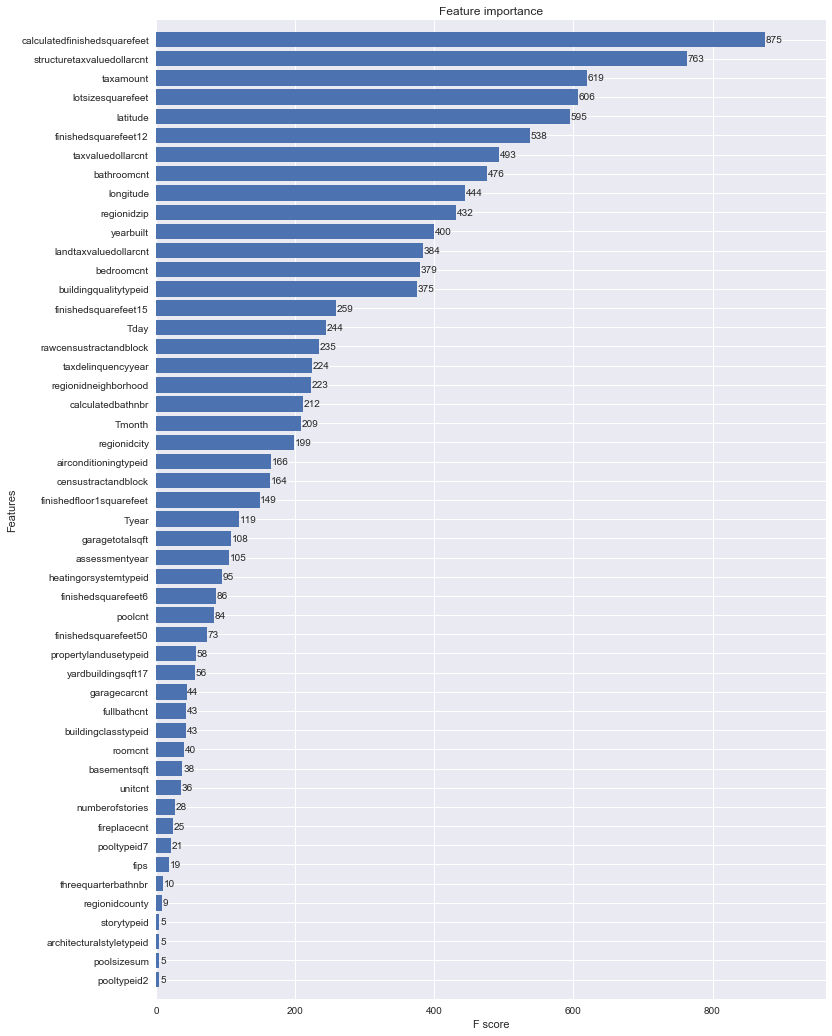

In [147]:
#*** Feature importance evaluation ***#

train_y = data_trans_reduced_comb_f['logerror'].values
df_train = data_trans_reduced_comb_f.drop(['parcelid', 'logerror','taxdelinquencyflag','fireplaceflag','propertyzoningdesc','propertycountylandusecode','hashottuborspa'], axis=1)
feat_names = df_train.columns.values

for c in df_train.columns:
    if df_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[c].values))
        df_train[c] = lbl.transform(list(df_train[c].values))

#import xgboost as xgb
#xgb_params = {
#    'eta': 0.05,
#    'max_depth': 8,
#    'subsample': 0.7,
#    'colsample_bytree': 0.7,
#    'objective': 'reg:linear',
#    'silent': 1,
#    'seed' : 0
#}

xgb_params = {
    'eta': 0.001,
    'max_depth': 8,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}


dtrain = xgb.DMatrix(df_train, train_y, feature_names=df_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

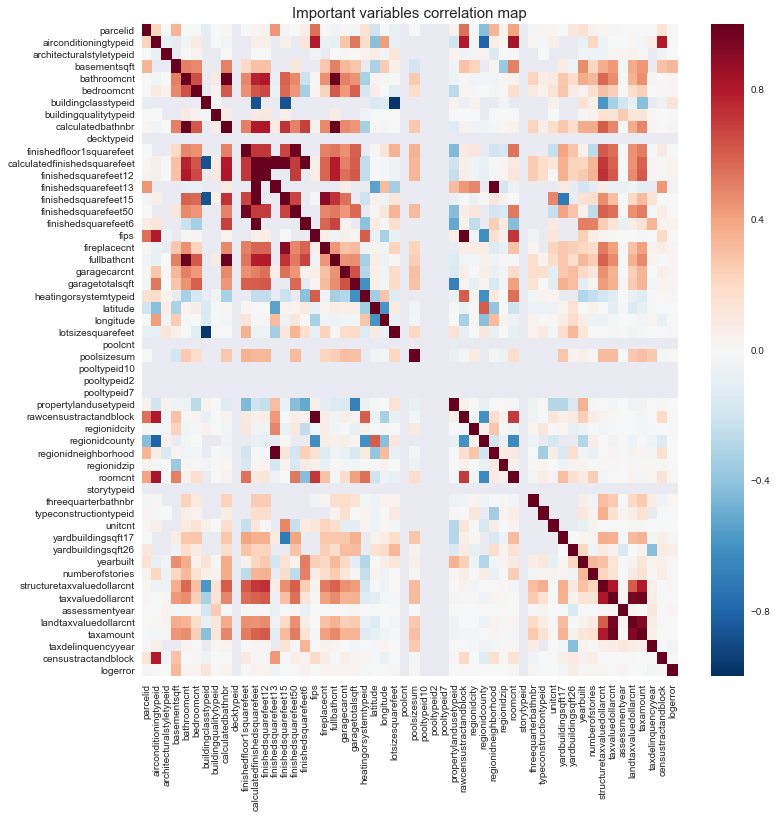

In [12]:
plot_corr(data_trans_reduced_comb_f)

### Outliers analysis

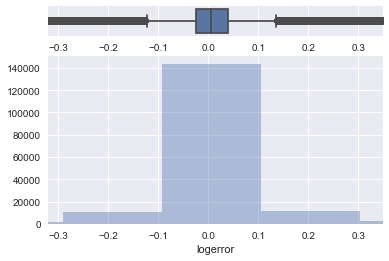

In [285]:
box_plot(data_trans_reduced_comb_f,'logerror')

In [468]:
data_with_Outliers = data_trans_reduced_comb_f.copy()

In [469]:
#data with reasonable outliers removed
data_trans_reduced_comb_f = data_trans_reduced_comb_f[data_trans_reduced_comb_f['calculatedfinishedsquarefeet']!=2]
data_trans_reduced_comb_f = data_trans_reduced_comb_f[data_trans_reduced_comb_f['structuretaxvaluedollarcnt'] >= 500]
data_trans_reduced_comb_f = data_trans_reduced_comb_f[data_trans_reduced_comb_f['taxvaluedollarcnt'] >= 1000]

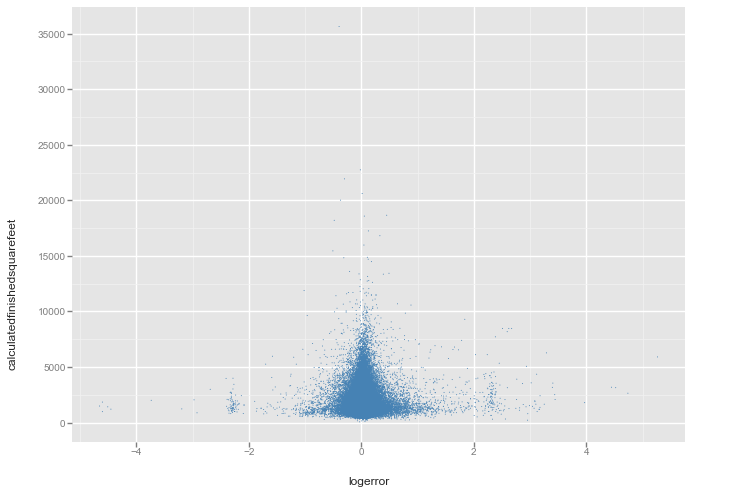

<ggplot: (745505389)>

In [470]:
#def plot_ggplot(df,xlabel,ylabel):
ggplot(aes(x='logerror', y='calculatedfinishedsquarefeet'), data=data_trans_reduced_comb_f) + \
    geom_point(color='steelblue', size=1) + \
    stat_smooth()    

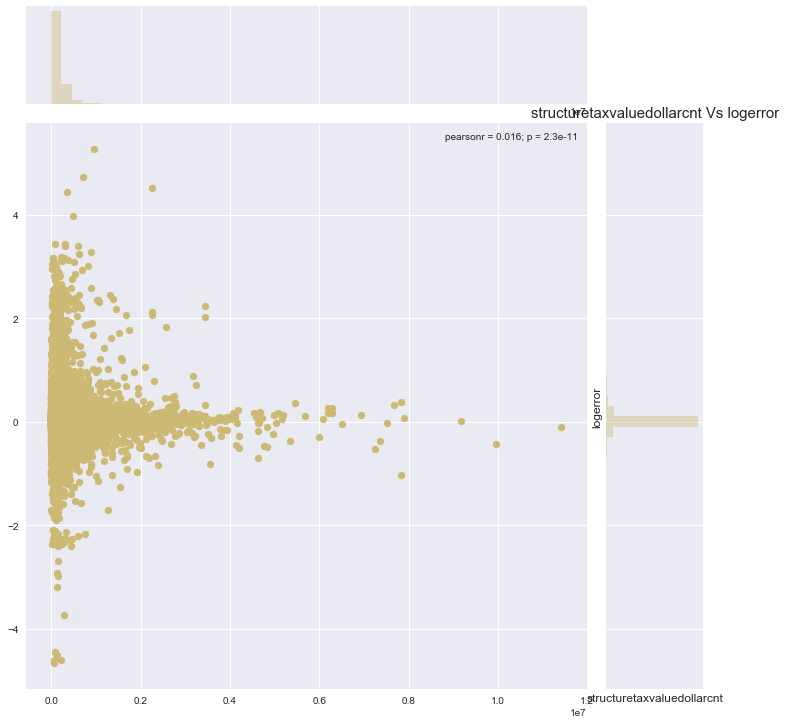

In [471]:
plot_jointplot(data_trans_reduced_comb_f,'structuretaxvaluedollarcnt','logerror')

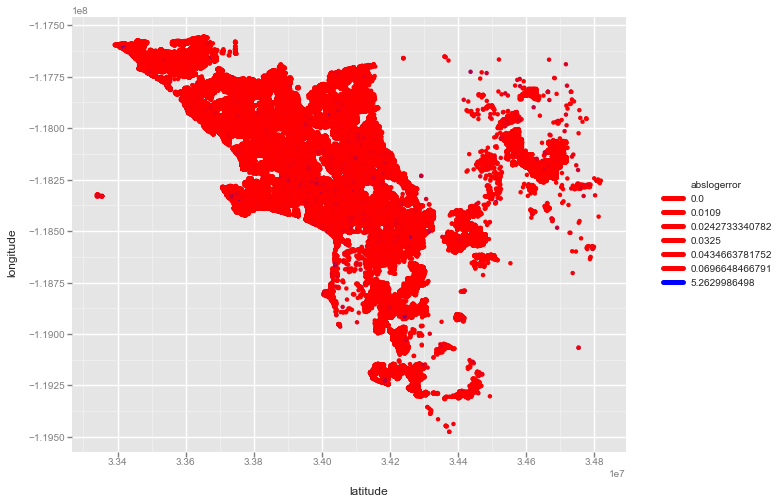

<ggplot: (764774337)>

In [472]:
t = data_trans_reduced_comb_f.copy()
t['abslogerror'] = t['logerror'].abs()
ggplot(aes(x='latitude', y='longitude', color='abslogerror'), data=t) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')    

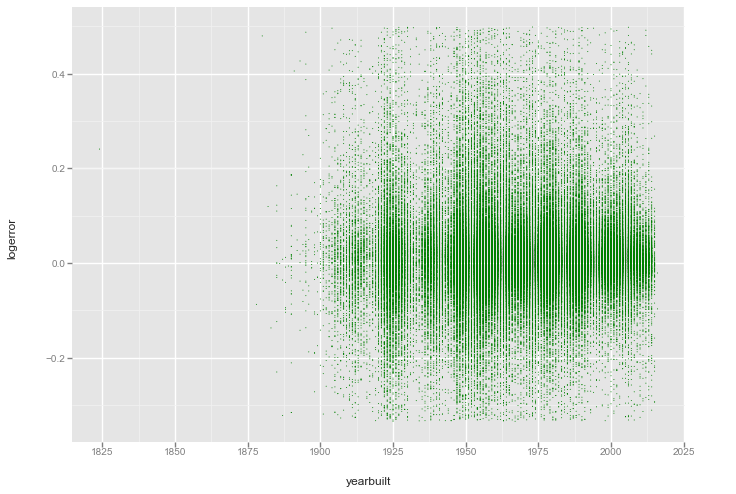

<ggplot: (353471881)>

In [473]:
t = data_trans_reduced_comb_f.copy()
t = t.loc[(t['logerror'] < t['logerror'].quantile(0.99)) & (t['logerror'] > t['logerror'].quantile(0.01)),:]
ggplot(aes(x='yearbuilt', y='logerror'), data=t) + \
    geom_point(color='green', size=1) + \
    stat_smooth()    

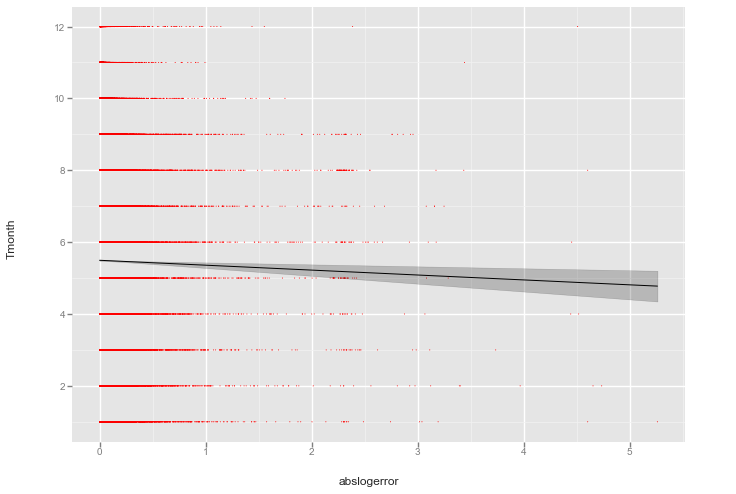

<ggplot: (320719909)>

In [474]:
t = data_trans_reduced_comb_f.copy()
t['abslogerror'] = t['logerror'].abs()
t['Tmonth'] = t['Tmonth'].astype(int)
ggplot(aes(x='abslogerror', y='Tmonth'), data=t) + \
    geom_point(color='red', size=1) + \
    stat_smooth()    

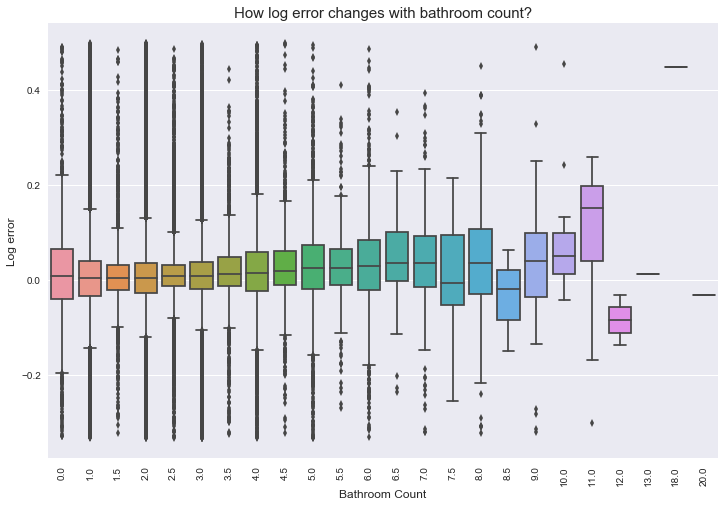

In [475]:
plt.figure(figsize=(12,8))
t = t.loc[(t['logerror'] < t['logerror'].quantile(0.99)) & (t['logerror'] > t['logerror'].quantile(0.01)),:]
sns.boxplot(x="bathroomcnt", y="logerror", data=t)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

### 3. Data Preprocessing

**Remove columns that are technically/semantically similar or that have most of the values as nulls**

In [487]:
dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6']

#finishedsquarefeet50 and finishedfloor1squarefeet are the exactly the same information according to the dictionary descriptions, lets remove finishedsquarefeet50 as it has more missing values
#'bathroomcnt' and 'calculatedbathnbr' and 'fullbathcnt' seem to be the same information aswell according to the dictionary descriptions. Choose 'bathroomcnt' as has no missing values, so remove the other two
dropcols.append('finishedsquarefeet50')
dropcols.append('calculatedbathnbr')
dropcols.append('fullbathcnt')
dropcols.append('taxvaluedollarcnt')
dropcols.append('finishedfloor1squarefeet')
dropcols.append('calculatedbathnbr')
dropcols.append('fireplaceflag')
dropcols.append('garagecarcnt')
dropcols.append('pooltypeid7')
dropcols.append('regionidcounty')
dropcols.append('regionidcity')
dropcols.append('regionidzip')
dropcols.append('regionidneighborhood')
dropcols.append('assessmentyear')
dropcols.append('propertycountylandusecode')
dropcols.append('propertylandusetypeid')
dropcols.append('censustractandblock')
dropcols.append('threequarterbathnbr')
dropcols.append('roomcnt')
dropcols.append('fips')
dropcols.append('poolcnt')

In [488]:
after_remov_similar_col_df = data_trans_reduced_comb_f.copy()

In [489]:
ind1 = after_remov_similar_col_df['latitude'].isnull()
ind2 = after_remov_similar_col_df['longitude'].isnull()
after_remov_similar_col_df = after_remov_similar_col_df.loc[~ind1 & ~ind2, :]

In [490]:
missingvalues_prop = (after_remov_similar_col_df.isnull().sum()/len(after_remov_similar_col_df)).reset_index()
missingvalues_prop.columns = ['fields','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
print(missingvalues_prop)

                          fields  proportion
6            buildingclasstypeid    0.999808
13          finishedsquarefeet13    0.999634
3                   basementsqft    0.999448
41                   storytypeid    0.999448
46            yardbuildingsqft26    0.999006
49                 fireplaceflag    0.997628
2       architecturalstyletypeid    0.997198
43        typeconstructiontypeid    0.996873
16           finishedsquarefeet6    0.995263
9                     decktypeid    0.992490
29                  pooltypeid10    0.990426
28                   poolsizesum    0.989066
30                   pooltypeid2    0.986427
22                hashottuborspa    0.976854
55            taxdelinquencyflag    0.971338
56            taxdelinquencyyear    0.971338
45            yardbuildingsqft17    0.970105
14          finishedsquarefeet15    0.960567
15          finishedsquarefeet50    0.923435
10      finishedfloor1squarefeet    0.923435
18                  fireplacecnt    0.893721
42        

In [491]:
after_remov_similar_col_df = after_remov_similar_col_df.drop(dropcols, axis=1)

In [492]:
dropcols = missingvalues_prop.loc[(missingvalues_prop['proportion']>0.97),'fields']
dropcols = dropcols[(dropcols !='buildingclasstypeid') & (dropcols !='poolsizesum') &
                    (dropcols !='typeconstructiontypeid') & (dropcols !='architecturalstyletypeid') & 
                    (dropcols !='finishedsquarefeet13') & (dropcols !='fireplaceflag') & 
                    (dropcols !='finishedsquarefeet6')  & (dropcols !='yardbuildingsqft17')
                   ]

In [493]:
after_remov_similar_col_df = after_remov_similar_col_df.drop(dropcols, axis=1)

**Imputation**

In [494]:
cols_to_be_knn = ['yearbuilt','airconditioningtypeid','heatingorsystemtypeid','buildingclasstypeid',
                  'fireplacecnt','typeconstructiontypeid','architecturalstyletypeid','buildingqualitytypeid',
                  'numberofstories','unitcnt','propertyzoningdesc','poolsizesum']
for col in cols_to_be_knn:
    fillna_knn(after_remov_similar_col_df,['latitude','longitude'],col)

In [495]:
cols_to_be_knn_reg = ['landtaxvaluedollarcnt','taxamount','calculatedfinishedsquarefeet',
                      'garagetotalsqft','yardbuildingsqft17','lotsizesquarefeet']
for col in cols_to_be_knn_reg:
    fillna_knn_reg(after_remov_similar_col_df,['latitude','longitude'],col)

In [496]:
after_remov_similar_col_df.isnull().sum()

parcelid                        0
airconditioningtypeid           0
architecturalstyletypeid        0
bathroomcnt                     0
bedroomcnt                      0
buildingclasstypeid             0
buildingqualitytypeid           0
calculatedfinishedsquarefeet    0
fireplacecnt                    0
garagetotalsqft                 0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolsizesum                     0
propertyzoningdesc              0
rawcensustractandblock          0
typeconstructiontypeid          0
unitcnt                         0
yardbuildingsqft17              0
yearbuilt                       0
numberofstories                 0
structuretaxvaluedollarcnt      0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
Tyear                           0
Tmonth                          0
Tday                            0
dtype: int64

In [497]:
after_enc_by_pop_df = after_remov_similar_col_df.copy()

**Convert the string columns to numerical using LabelEncoding**

In [498]:
lbl = preprocessing.LabelEncoder()
lbl.fit(list(after_enc_by_pop_df['propertyzoningdesc'].values)) 
after_enc_by_pop_df['propertyzoningdesc'] = lbl.transform(list(after_enc_by_pop_df['propertyzoningdesc'].values))

**For numerical columns with non-ordinal values, reassign the values per their order in the total population** 

In [499]:
idx = []
for col in cols_to_be_knn:
    if col != 'yearbuilt':
        idx = after_enc_by_pop_df[col].value_counts().sort_values().index
        newval = after_enc_by_pop_df[col].max() + 1
        for i in range(len(idx)):
            after_enc_by_pop_df.loc[after_enc_by_pop_df[col]==idx[i],col] = newval
            newval += 1
    idx = []
    newval = 0
del idx, newval

In [500]:
after_scaling_df = after_enc_by_pop_df.copy()

In [501]:
after_scaling_df = after_scaling_df.drop(['parcelid'],axis=1)

In [502]:
scaling_finished_df = after_scaling_df.copy()

** Feature Engineering **

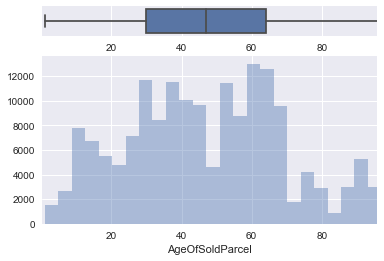

In [503]:
scaling_finished_df['Tyear'] = scaling_finished_df['Tyear'].astype(float)
scaling_finished_df['AgeOfSoldParcel'] =  scaling_finished_df['Tyear'] - scaling_finished_df['yearbuilt']
scaling_finished_df['Tyear'] = scaling_finished_df['Tyear'] - scaling_finished_df['Tyear'].min()
scaling_finished_df = scaling_finished_df.drop(['Tyear','yearbuilt'],axis=1)
box_plot(scaling_finished_df,'AgeOfSoldParcel')

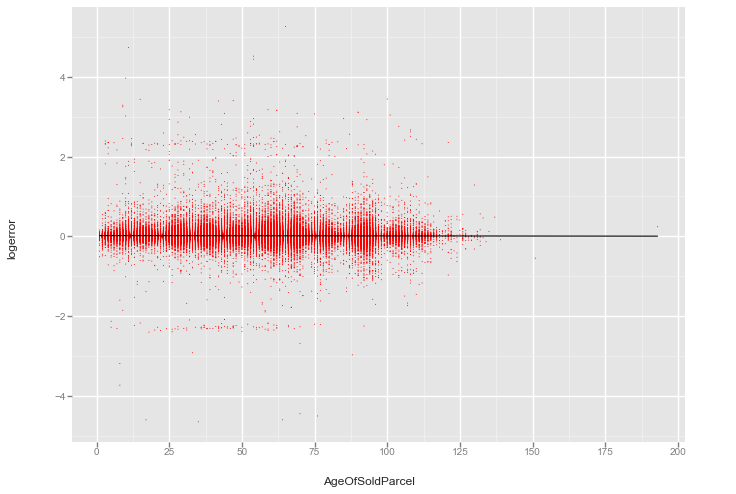

<ggplot: (320685105)>

In [504]:
t = after_scaling_df.copy()
t['Tyear'] = t['Tyear'].astype(float)
t['AgeOfSoldParcel'] =  t['Tyear'] - t['yearbuilt']
t['Tyear'] = t['Tyear'] - t['Tyear'].min()
ggplot(aes(x='AgeOfSoldParcel', y='logerror'), data=t) + \
    geom_point(color='red', size=1) + \
    stat_smooth()

**Scaling / normalizing the features using RobustScaler.**

In [505]:
for col in scaling_finished_df.columns.values:
    if col != 'logerror' :
        scaler = RobustScaler().fit(scaling_finished_df[col].values.reshape(-1, 1))
        scaling_finished_df[col] = scaler.transform(scaling_finished_df[col].values.reshape(-1, 1))

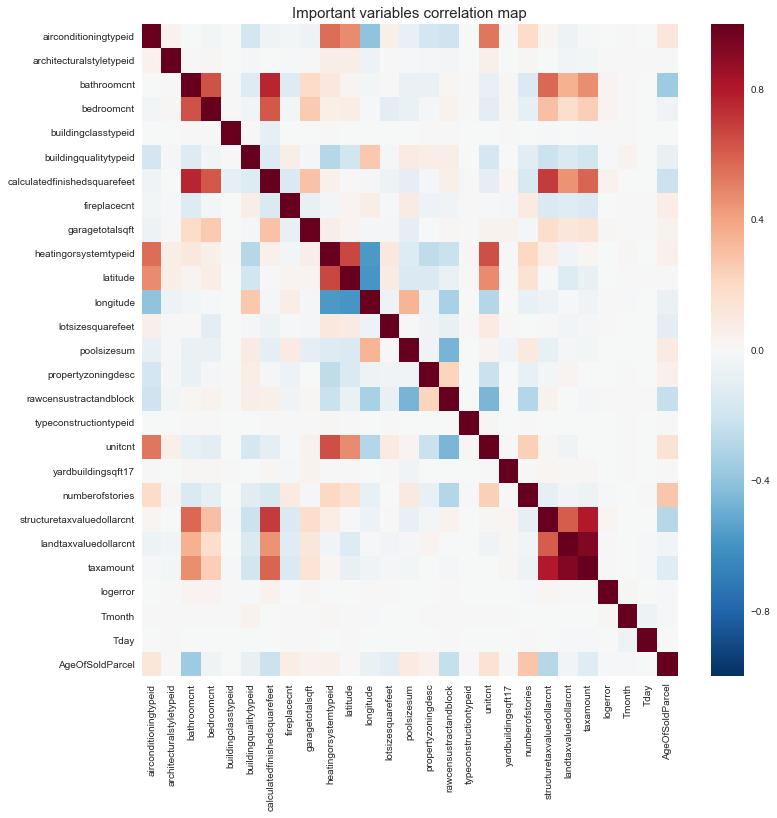

In [506]:
plot_corr(scaling_finished_df)

In [507]:
x_cols = [col for col in scaling_finished_df.columns if col not in ['abslogerror','logerror'] if (scaling_finished_df[col].dtype=='float64' or scaling_finished_df[col].dtype=='int64')]

In [508]:
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(scaling_finished_df[col].values, scaling_finished_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
corr_df

,col_labels,corr_values
19,numberofstories,-0.011261
25,AgeOfSoldParcel,-0.010068
5,buildingqualitytypeid,-0.009981
7,fireplacecnt,-0.006422
24,Tday,-0.004686
14,propertyzoningdesc,-0.004443
17,unitcnt,-0.004170
18,yardbuildingsqft17,-0.003814
10,latitude,-0.002285
9,heatingorsystemtypeid,-0.002119


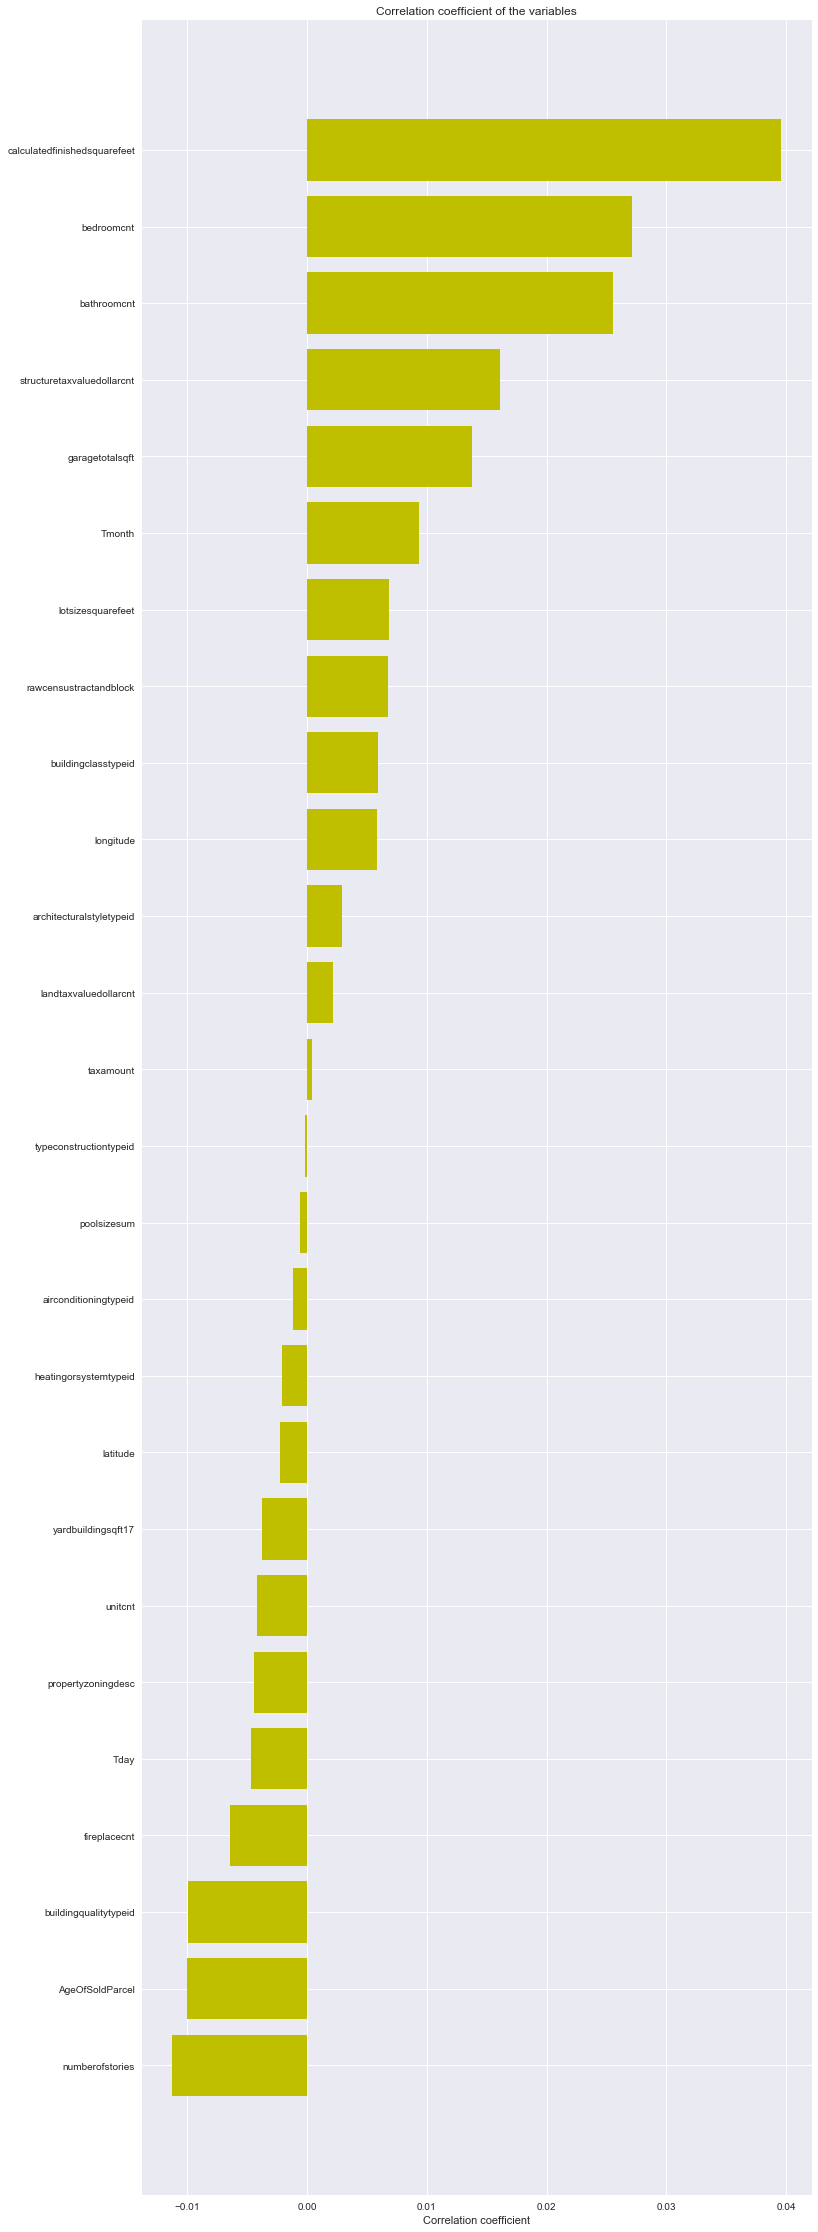

In [509]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
'''
fontdict = {'fontsize': 22,
 'fontweight': mlp.rcParams['axes.titleweight'],
 'verticalalignment': 'baseline'}
'''
ax.set_yticklabels(corr_df.col_labels.values,rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [510]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.006) | (corr_df['corr_values'] < -0.002)]

In [513]:
l = corr_df_sel['col_labels'].values
l = np.append(l,'logerror')
after_corr_df = scaling_finished_df.copy()
cols_to_del = [col for col in after_corr_df.columns.values if col not in l] 
after_corr_df = after_corr_df.drop(cols_to_del,axis=1)
after_corr_feat_df = after_corr_df.drop('logerror',axis=1)

## 4. Building the model

In [514]:
X_train_1st, X_test, y_train_1st, y_test = train_test_split(after_corr_feat_df,after_corr_df['logerror'],test_size=0.25, random_state=42)

# Success
print "Training and testing split was successful."
print X_train_1st.shape
print y_train_1st.shape
print X_test.shape
print y_test.shape

Training and testing split was successful.
(129027, 18)
(129027,)
(43010, 18)
(43010,)


In [515]:
X_test_1, X_test_2, y_test_1,y_test_2 = train_test_split(X_test,y_test,test_size=0.5, random_state=28)

In [516]:
split = 100000
X_train, y_train, X_valid, y_valid = X_train_1st[:split], y_train_1st[:split], X_train_1st[split:], y_train_1st[split:]

**Naive model : only predicts mean of the training data**

('absolute whole test error ', 0.071141060579504617)
('Variance or R^2 score for test', -6.8658778751284899e-07)


Text(0,0.5,u'actuals')

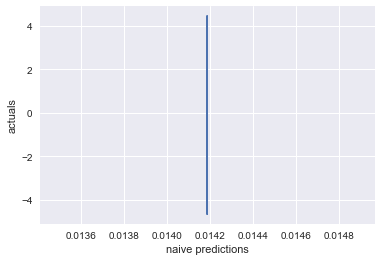

In [517]:
y_pred = np.mean(y_train_1st)
y_naive = [y_pred for i in range(len(y_test))]
print('absolute whole test error ',mean_absolute_error(y_test,y_naive))
print('Variance or R^2 score for test',r2_score(y_test,y_naive))
plt.plot(y_naive,y_test)
plt.xlabel('naive predictions')
plt.ylabel('actuals')

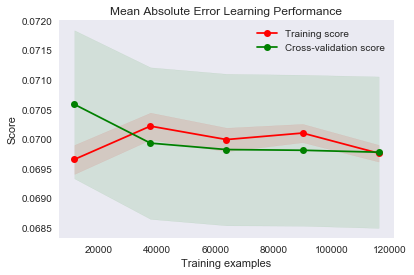

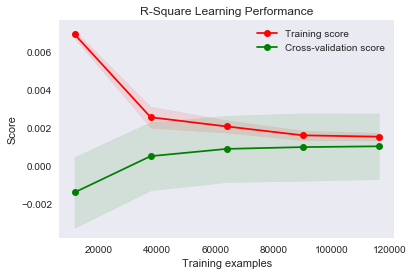

In [518]:
lr = LinearRegression(fit_intercept=False)
#plot_learning_curve(lr,'MAE Learning Performance',X_train_1st,y_train_1st,cv=10,scoring='mean_absolute_error')
plot_learning_curve(lr,'Mean Absolute Error Learning Performance',X_train_1st,y_train_1st,cv=10,scoring=performance_metric)
plot_learning_curve(lr,'R-Square Learning Performance',X_train_1st,y_train_1st,cv=10,scoring='r2')
plt.show()

('absolute total test error', 0.070886105004031461)


Text(0,0.5,u'actuals')

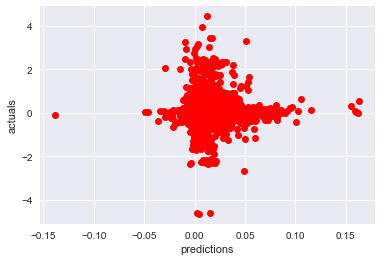

In [519]:
lr.fit(X_train_1st,y_train_1st)
lrpredtest = lr.predict(X_test)
print('absolute total test error', mean_absolute_error(y_test,lrpredtest))
plt.plot(lrpredtest,y_test,'ro')
plt.xlabel('predictions')
plt.ylabel('actuals')

('absolute total test error', 0.070940416523572844)


<module 'matplotlib.pyplot' from '/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/matplotlib-2.1.0rc1+108.g4fe22e1-py2.7-macosx-10.7-x86_64.egg/matplotlib/pyplot.pyc'>

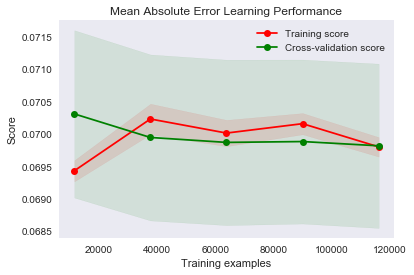

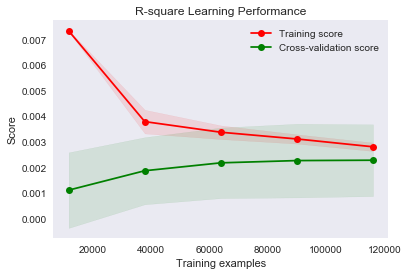

In [520]:
br = BayesianRidge(n_iter=1000)
br.fit(X_train_1st,y_train_1st)
print('absolute total test error', mean_absolute_error(y_test,br.predict(X_test)))
plot_learning_curve(br,'Mean Absolute Error Learning Performance',X_train_1st,y_train_1st,cv=10,scoring=performance_metric)
plot_learning_curve(br,'R-square Learning Performance',X_train_1st,y_train_1st,cv=10,scoring='r2')

Text(0,0.5,u'actuals')

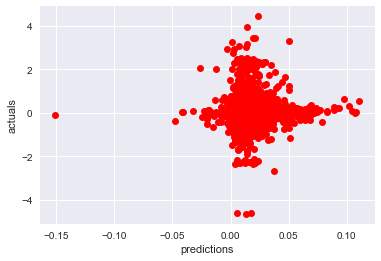

In [521]:
plt.plot(br.predict(X_test),y_test,'ro')
plt.xlabel('predictions')
plt.ylabel('actuals')

<module 'matplotlib.pyplot' from '/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/matplotlib-2.1.0rc1+108.g4fe22e1-py2.7-macosx-10.7-x86_64.egg/matplotlib/pyplot.pyc'>

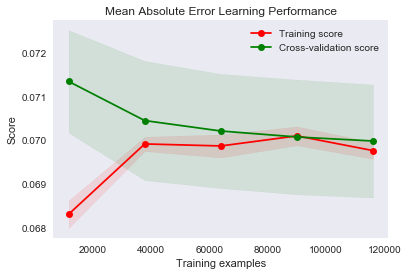

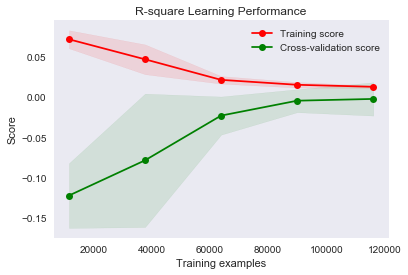

In [522]:
clf = DecisionTreeRegressor(max_depth=4)
clf = clf.fit(X_train_1st, y_train_1st)
plot_learning_curve(clf,'Mean Absolute Error Learning Performance',X_train_1st,y_train_1st,cv=10,scoring=performance_metric)
plot_learning_curve(clf,'R-square Learning Performance',X_train_1st,y_train_1st,cv=10,scoring='r2')

0.0711217808508


Text(0,0.5,u'actuals')

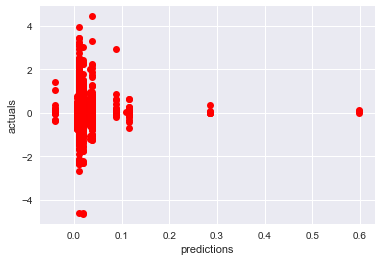

In [524]:
#mean_absolute_error(y_test,clf.predict(X_test))
clf = DecisionTreeRegressor(max_depth=4)
clf.fit(X_train_1st, y_train_1st)
print(mean_absolute_error(y_test,clf.predict(X_test)))
plt.plot(clf.predict(X_test),y_test,'ro')
plt.xlabel('predictions')
plt.ylabel('actuals')

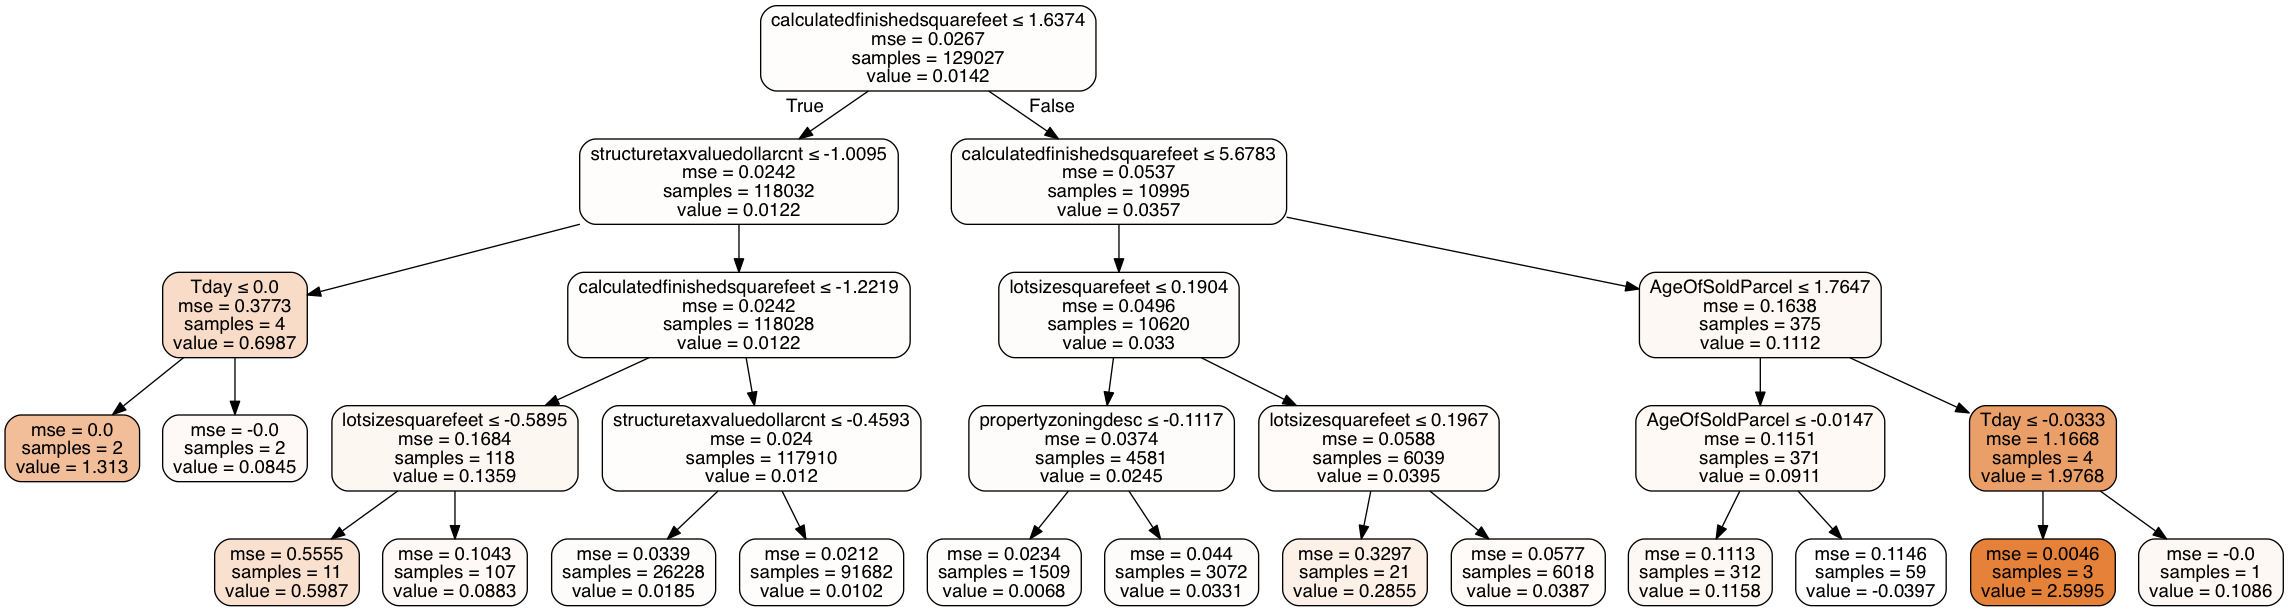

In [525]:
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,
    feature_names=X_train.columns,
    class_names="Log Error",
    filled=True, rounded=True,
    special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

In [526]:
# stats for XGBoost regressor
#    'eta': 0.001,
#   'max_depth': 8,
#    'subsample': 0.6,
#    'colsample_bytree': 0.6,
#      num_boost_round : 8000

start = time()
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid, y_valid)

xgb_params = {
    'eta': 0.001,
    'max_depth': 8,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0,
    'eval_metric':'mae'
}
    
evals = [(d_train, 'train'), (d_valid, 'valid')]

xgbmodel = xgb.train(xgb_params,d_train,evals=evals,num_boost_round=8000, 
                        early_stopping_rounds=100, verbose_eval=800)

end = time()
print('time taken ', end-start)
pred = xgbmodel.predict(d_valid)
e = mean_absolute_error(y_valid,pred)
end = time()

print('time taken ', end-start)
print ('For validation absolute error', e)

[0]	train-mae:0.494982	valid-mae:0.494903
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[800]	train-mae:0.237134	valid-mae:0.236847
[1600]	train-mae:0.129461	valid-mae:0.129187
[2400]	train-mae:0.088154	valid-mae:0.087807
[3200]	train-mae:0.074373	valid-mae:0.074208
[4000]	train-mae:0.070113	valid-mae:0.070231
[4800]	train-mae:0.068633	valid-mae:0.069052
[5600]	train-mae:0.067955	valid-mae:0.068691
[6400]	train-mae:0.067515	valid-mae:0.068594
Stopping. Best iteration:
[6713]	train-mae:0.067376	valid-mae:0.068582

('time taken ', 429.94483399391174)
('time taken ', 429.9564960002899)
('For validation absolute error', 0.068581747810534888)


In [528]:
d_test = xgb.DMatrix(X_test)
eT = mean_absolute_error(y_test,xgbmodel.predict(d_test))
print ('For test absolute error', eT)
print('Variance or R^2 score for test',r2_score(y_test,xgbmodel.predict(d_test)))

('For test absolute error', 0.071175278483041213)
('Variance or R^2 score for test', 0.01203842202487504)


Text(0,0.5,u'actuals')

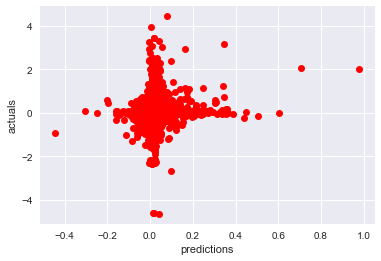

In [529]:
plt.plot(xgbmodel.predict(d_test),y_test,'ro')
plt.xlabel('predictions')
plt.ylabel('actuals')

In [215]:
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

#clf = xgb.train(xgb_params, d_train, 100, watchlist, verbose_eval=10) 

#same as clf results above
#model = xgb.train(xgb_params, d_train, 100)
start = time()
model = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=1000, subsample=0.8, 
                                  max_depth=6 )
model = model.fit(X_train, y_train)
#xgb_pred = model.predict(d_valid)
pred = model.predict(X_valid)
e = mean_absolute_error(y_valid,pred)
end = time()
pred = model.predict(X_test_1)
eT = mean_absolute_error(y_test_1,pred)

In [216]:
# stats for Gradient Boost regressor for test_1 sample (no training)
print('time taken ', end-start)
print ('absolute val error ', e)
print ('absolute test1 error ', eT)

('time taken ', 208.71707701683044)
('absolute val error ', 0.078719798242216976)
('absolute test1 error ', 0.078486862384852182)


In [127]:
# stats for XGBoost regressor for validation sample with training for config1
#    'eta': 0.001,
#   'max_depth': 7,
#    'subsample': 0.6,
#    'colsample_bytree': 0.6,
#      num_boost_round : 1000
#('time taken ', 33.103821992874146)
#('For validation absolute error', 0.20116051535827803)
#('For test1 absolute error', 0.20362736794131872)
#('For test2 absolute error', 0.20131972953020882)

#Same params as above except num of rounds changed to 4000
#('time taken ', 136.028058052063)
#('For validation absolute error', 0.071717596593644975)
#('For test1 absolute error', 0.072838143769358835)
#('For test2 absolute error', 0.071991483327164693)

#Same params as above except num of rounds changed to 7000
#('time taken ', 236.4542829990387)
#('For validation absolute error', 0.070213234593663229)
#('For test1 absolute error', 0.071112350982830058)
#('For test2 absolute error', 0.070433131174363728)
#('For entire test absolute error', 0.070772741078596865)

#For Same params as above except num of rounds changed to 8000, the test score worsened but better than when 
# eta changed to 0.002. Stats below are for when eta = 0.002
#('time taken ', 264.83625292778015)
#('For validation absolute error', 0.070984233595956667)
#('For test1 absolute error', 0.071817976989387897)
#('For test2 absolute error', 0.071198882471344593)
#('For entire test absolute error', 0.071508429730366238)
#For same boosting rounds and other params as above except eta = 0.0005:
#('time taken ', 259.9542860984802)
#('For validation absolute error', 0.071717449000867697)
#('For test1 absolute error', 0.072837269011416253)
#('For test2 absolute error', 0.071978137823392102)

#Same params as above except num of rounds changed to 10000. Eta = 0.001
#('time taken ', 333.6889901161194)
#('For validation absolute error', 0.070441836447831585)
#('For test1 absolute error', 0.071310751291463789)
#('For test2 absolute error', 0.070645614387189179)

# stats for XGBoost regressor for validation sample with training
#    'eta': 0.001,
#   'max_depth': 8,
#    'subsample': 0.6,
#    'colsample_bytree': 0.6,
#      num_boost_round : 8000
#('time taken ', 302.78505301475525)
#('For validation absolute error', 0.070455379028505238)
#('For test1 absolute error', 0.071333359708868713)
#('For test2 absolute error', 0.070661196423281086)

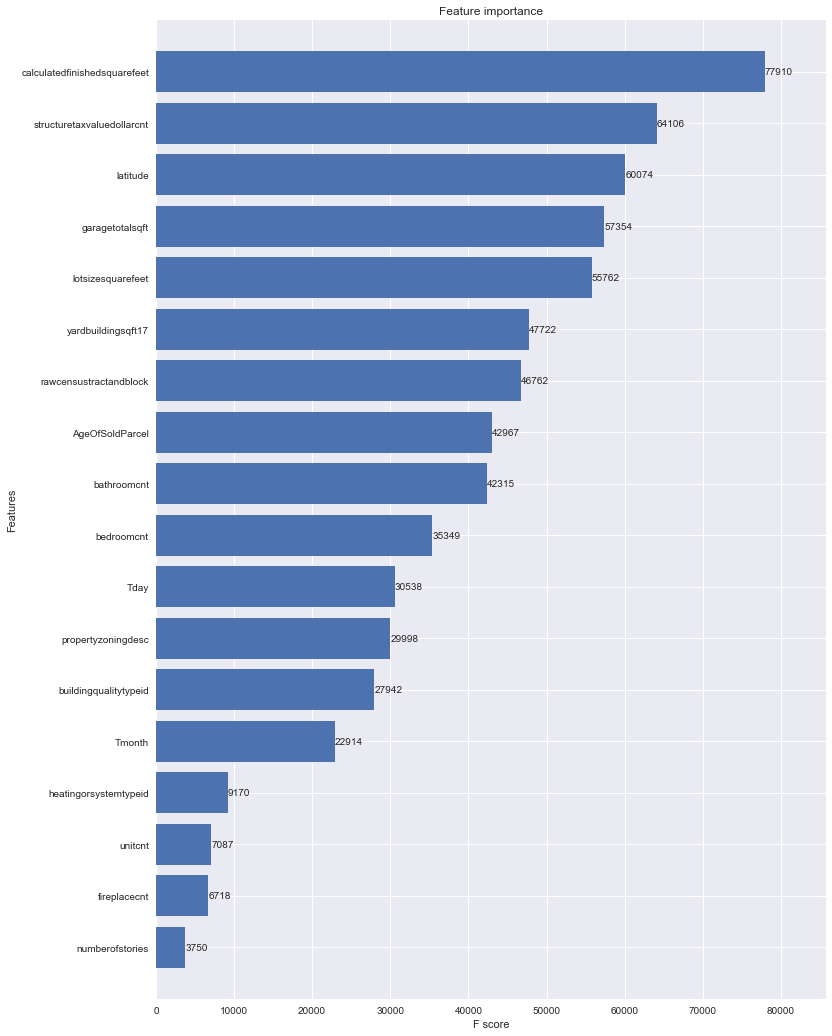

In [530]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgbmodel, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
d = {'eta':0.005,'max_depth':8,'subsample':0.7,'colsample_bytree':0.7 ,'num_boost_round':1000, 'valScore':0.070660886278811383, 
    'test1Score':0.071708082828990508, 'test2Score':0.070926445195721943}
finalRes = pd.DataFrame(data=d)